# Exploratory data analysis

I'll perform some exploratory data analysis to get a sense of what there is to work with in the PitchFX database. I'll do this by producing a number of plots to visually inspect our data.

To start, I will link relevant libraries.

In [1]:
# imports
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
%matplotlib inline

## Importing database

The first step is to connect to the database. I've already created a PitchFX database for the year 2008 using a framework introduced in *read_data.ipynb*, and I will connect to it here. The user will want to change `dbname` to the path of his/her personal database.

In [2]:
# specify database name
dbname = "../dat/pitchfx2008.db"

# connect to the sqlite3 database
db = sqlite3.connect(dbname)
hdb = db.cursor()

## Tables and data columns

Take a look at the tables and the corresponding columns associated with those tables. Here are the table names.

In [3]:
# table names
query = """SELECT name FROM sqlite_master WHERE type='table'"""
hdb.execute(query)
table_names = hdb.fetchall()
print(*table_names)

('games',) ('teams',) ('stadiums',) ('players',) ('umpires',) ('events',) ('pitchfx',)


There are a number of tables at our disposal. Now look at the column names in each of these tables.

In [4]:
for tt in table_names:
    query = "SELECT * FROM %s" %(tt[0])
    names = [description[0] for description in hdb.execute(query).description]
    print("%s\n %s\n" %(tt[0], names))

games
 ['game_id', 'game_type', 'date', 'game_time', 'home_id', 'home_wins', 'home_losses', 'visit_id', 'visit_wins', 'visit_losses', 'stadium_id', 'umpire_home', 'umpire_first', 'umpire_second', 'umpire_third']

teams
 ['team_id', 'team_name', 'team_abbr']

stadiums
 ['stadium_id', 'stadium_name']

players
 ['player_id', 'player_first', 'player_last', 'position', 'bats', 'throws', 'dob']

umpires
 ['umpire_id', 'umpire_name']

events
 ['game_id', 'event_id', 'event_description', 'inning', 'is_top_inning', 'pre_out', 'post_out', 'pitcher_id', 'batter_id', 'pre_1b', 'post_1b', 'pre_2b', 'post_2b', 'pre_3b', 'post_3b', 'post_home', 'pre_home_score', 'post_home_score', 'pre_away_score', 'post_away_score']

pitchfx
 ['game_id', 'pitch_num', 'at_bat', 'time', 'cur_event', 'description', 'outcome', 'pre_balls', 'post_balls', 'pre_strike', 'post_strike', 'start_speed', 'end_speed', 'sz_top', 'sz_bot', 'pfx_x', 'pfx_z', 'px', 'pz', 'x', 'y', 'x0', 'y0', 'z0', 'vx0', 'vy0', 'vz0', 'ax', 'ay', '

There are a number of tables that can be linked together, including the *pitchfx* and the *events* tables. The former table contains all the pitch trajectory and location information and contains most of the important numeric data, while the latter table ties those pitches to in-game events.

## Pitch types

I will start by looking at the data based on their classified pitch types.

### Pitch frequency

I'll look at what classifications pitches can have by looking at the `pitch_type` feature. I'll create a bar chart of all pitch classifications to get a sense of the distribution of pitches.

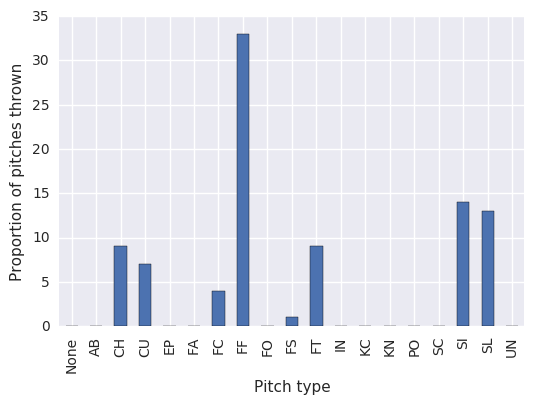

In [5]:
# grab pitch_type information
query = """SELECT pitch_type, 100*COUNT(pitch_type)/(SELECT COUNT(*) FROM pitchfx)
        FROM pitchfx
        GROUP BY pitch_type"""
ptype = pd.read_sql_query(query, db)

# plot histogram of pitch classifications
fig, ax = plt.subplots()
ptype.iloc[:, 1].plot.bar()
ax.set_xticklabels(ptype["pitch_type"])
ax.set_xlabel("Pitch type")
ax.set_ylabel("Proportion of pitches thrown")
plt.show()

A guide to the pitch labels provided by the database can be found at: https://www.fangraphs.com/library/pitch-type-abbreviations-classifications/. The four-seam fastbal (FF) is by far the most common pitch amongst pitchers, thrown over 35% of the time. The next two common pitches are sinkers (SI) and sliders (SL) at around 13%, followed by the two-seam fastball (FT) and changeup (CH) around 9%. The next common pitches are the curveball (CU) and the cut-fastball (FC).

### Four-seam fastball velocity variation

Since four-seam fastballs are the most common pitch, I'll look at how much they vary from pitcher to pitcher. First I'll compare the starting velocities of all fastballs from all pitchers in a histogram.

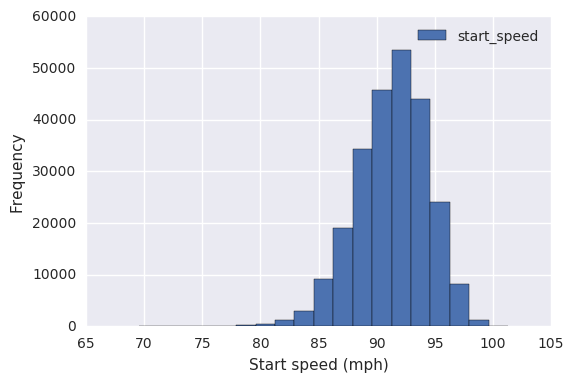

In [6]:
# get fastball information
query = """SELECT start_speed
        FROM pitchfx
        WHERE pitch_type='FF'"""
ff_speed = pd.read_sql_query(query, db)

# histogram of velocities
ff_speed.plot.hist(bins=20)
plt.xlabel("Start speed (mph)")
plt.show()

Most of the four-seamers sit at 92-93 mph. Next I'll look at how the speeds differ between left-handed and right-handed pitchers. To do this, I will need to join multiple tables, as the handedness of the pitcher is in the *player* table and the *events* table is needed to tie the pitcher to the pitch. I will then plot histograms for both handednesses in the same plot.

In [7]:
# left handers
query = """SELECT start_speed
        FROM pitchfx
        JOIN events ON (pitchfx.game_id=events.game_id
            AND pitchfx.cur_event=events.event_id)
        JOIN players ON (events.pitcher_id=players.player_id)
        WHERE pitchfx.pitch_type='FF'
            AND players.throws='L'"""
ff_speedL = pd.read_sql_query(query, db)

# right handers
query = """SELECT start_speed
        FROM pitchfx
        JOIN events ON (pitchfx.game_id=events.game_id
            AND pitchfx.cur_event=events.event_id)
        JOIN players ON (events.pitcher_id=players.player_id)
        WHERE pitchfx.pitch_type='FF'
            AND players.throws='R'"""
ff_speedR = pd.read_sql_query(query, db)

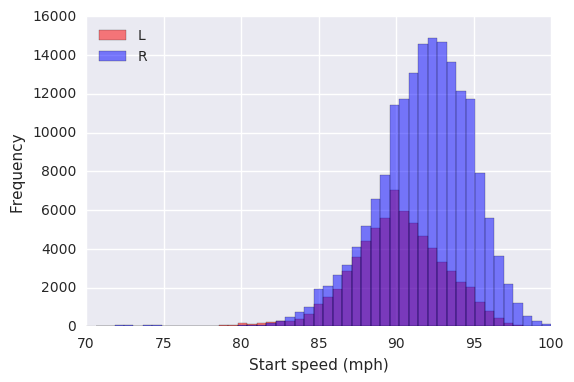

In [8]:
# plot histograms on top of each other
bins = np.linspace(70, 100, 50)
plt.hist(ff_speedL.as_matrix(), bins=bins, alpha=0.5, label='L', color='R')
plt.hist(ff_speedR.as_matrix(), bins=bins, alpha=0.5, label='R', color='B')
plt.legend(loc='upper left')
plt.xlabel("Start speed (mph)")
plt.ylabel("Frequency")
plt.show()

In general, left handers have slower four-seamers than right handers. This could be because left handers are less populous than right handers, so finding left-handers who can throw hard is difficult. I'll view the same data in boxplots.

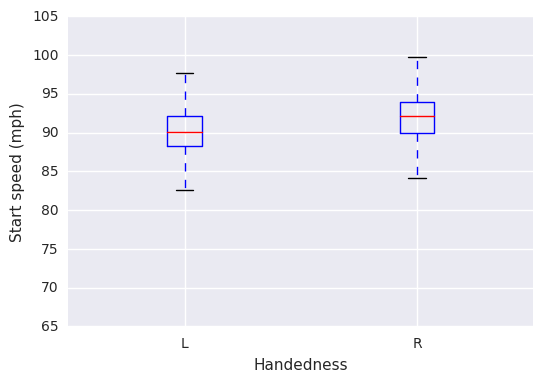

In [9]:
# plot boxplots of velocity by handedness
plt.boxplot([ff_speedL, ff_speedR], labels=['L', 'R'])
plt.xlabel("Handedness")
plt.ylabel("Start speed (mph)")
plt.show()

Clearly, the median velocity of four-seamers is slower for left handers than for right handers. This partially explains why hard-throwing left handers are coveted by teams: they're rare.

### Slider movement

Previously, it was clear that the four-seamer can vary significantly from pitcher to pitcher. Four-seamers typically have relatively little movement. Here, I'll look more closely at the most common breaking pitch, which is the slider. I expect to see variations in not only velocity, but also horizontal and vertical movement.

Because sliders break differently depending on handedness, I will focus on sliders thrown by righties. In addition to the starting speed, I will also grab the horizontal and vertical movements (in inches), as well as spin rate. I chose these parameters based on human intution.

In [10]:
query = """SELECT start_speed, pfx_x, pfx_z, spin_rate
        FROM pitchfx
        JOIN events ON (pitchfx.game_id=events.game_id
            AND pitchfx.cur_event=events.event_id)
        JOIN players ON (events.pitcher_id=players.player_id)
        WHERE pitchfx.pitch_type='SL'
            AND players.throws='R'"""
sl_speed_move = pd.read_sql_query(query, db)

Take a look at density plots of sliders in horizontal and vertical movement space.

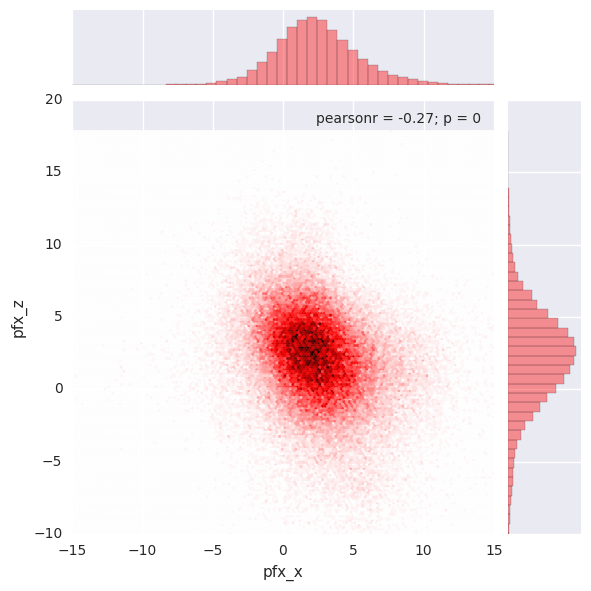

In [11]:
# create density plot of accelerations
sns.jointplot(sl_speed_move["pfx_x"],
              sl_speed_move["pfx_z"],
              color="red",
              kind="hex",
              xlim=[-15, 15],
              ylim=[-10, 20],)
plt.show()

Compare the spread in movement in the slider to those in the four-seamer.

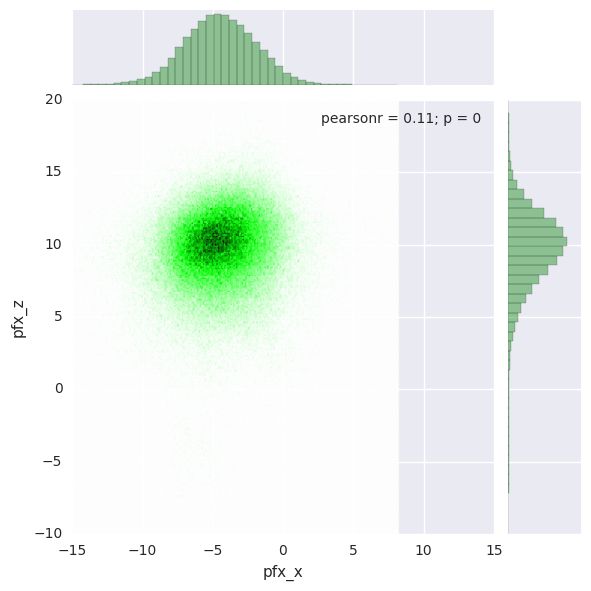

In [12]:
query = """SELECT start_speed, pfx_x, pfx_z, spin_rate
        FROM pitchfx
        JOIN events ON (pitchfx.game_id=events.game_id
            AND pitchfx.cur_event=events.event_id)
        JOIN players ON (events.pitcher_id=players.player_id)
        WHERE pitchfx.pitch_type='FF'
            AND players.throws='R'"""
ff_speed_move = pd.read_sql_query(query, db)

# create density plot of accelerations
sns.jointplot(ff_speed_move["pfx_x"],
              ff_speed_move["pfx_z"],
              color="green",
              kind="hex",
              xlim=[-15, 15],
              ylim=[-10, 20],)
plt.show()

The spread in movements in the horizontal and vertical directions are smaller for the four-seamer than the slider. This result suggests that sliders come in more "flavors" than four-seamers. Some sliders may have more horizontal break than others, while some sliders may have more vertical break than others. Note that these results assume that the labels from the database are "correct".

Additionally, four-seamers and sliders have very different trajectories. These plots suggest that pitch types may be distinguished based on the numerical variables in the database.

### Pitch separation

Next, I'll look at crossplots of movements, velocity, and given pitch classifications to see if pitch types can visually be separated. I'll look at left-handers first.

In [13]:
# grab pitchfx table for right handers
query = """SELECT pitchfx.*
        FROM pitchfx
        JOIN events ON (pitchfx.game_id=events.game_id
            AND pitchfx.cur_event=events.event_id)
        JOIN players ON (events.pitcher_id=players.player_id)
        WHERE players.throws='L'"""
pitchfxL = pd.read_sql_query(query, db)

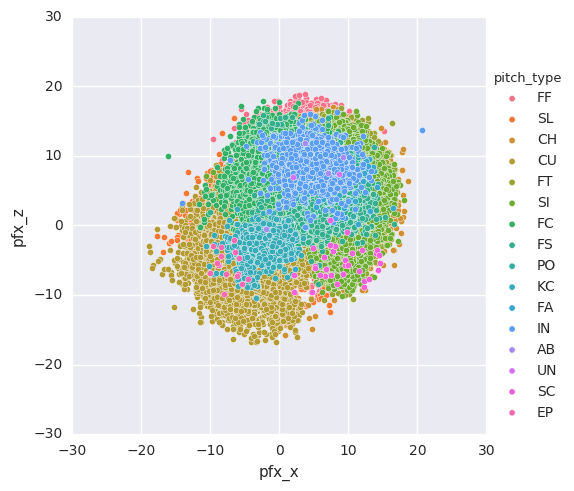

In [14]:
# plot crossplot over movements
sns.pairplot(x_vars="pfx_x",
             y_vars="pfx_z",
             data=pitchfxL,
             hue="pitch_type",
             size=5,)
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.show()

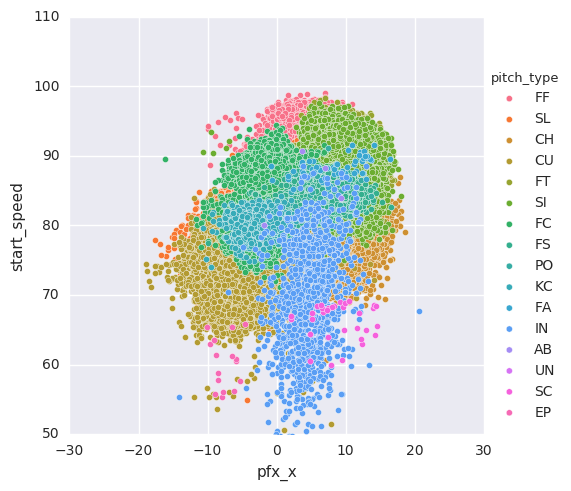

In [15]:
# plot crossplot over horizontal movement and velocity
sns.pairplot(x_vars="pfx_x",
             y_vars="start_speed",
             data=pitchfxL,
             hue="pitch_type",
             size=5,)
plt.xlim(-30, 30)
plt.ylim(50, 110)
plt.show()

From these plots, it is apparent why general pitch classification is a difficult task. The left-handed pitches do not cluster cleanly based on these particular subset of features. As seen previously, not every slider is the same, not every curveball is the same, and not every fastball is the same. Therefore, it'll be useful to look at a specific pitcher in order to classify pitches based solely on trajectory information.

## Single pitcher pitch trajectories

I'll focus on Barry Zito, a soft-throwing left hander with a big curveball.

In [16]:
# get BZ's information
query = """SELECT DISTINCT pitchfx.* 
        FROM pitchfx
        JOIN events ON (pitchfx.game_id=events.game_id
            AND pitchfx.cur_event=events.event_id)
        WHERE events.pitcher_id=(SELECT player_id
            FROM players
            WHERE players.player_first='Barry'
                AND players.player_last='Zito')
        ORDER BY game_id, pitch_num"""
bz_pfx = pd.read_sql_query(query, db)

### Data cleaning

I'll first look for Nans in this particular dataframe. I'll plot a matrix of zeros except for where the Nans are.

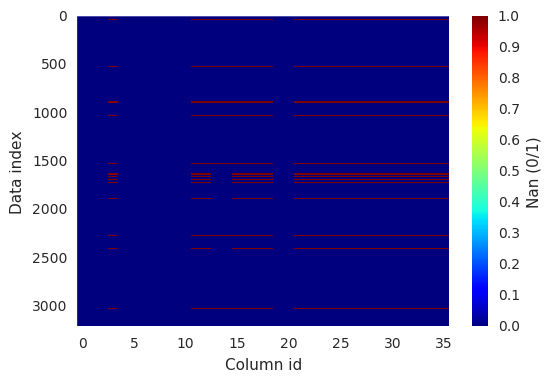

fraction of data points containing Nans:  0.032439176544


In [17]:
# view rows containing Nans
inans = bz_pfx.isnull()
plt.imshow(inans,
          aspect='auto',
          cmap="jet",
          interpolation='none',)
plt.xlabel('Column id')
plt.ylabel('Data index')
plt.grid(False)
plt.colorbar(label="Nan (0/1)")
plt.show()

# fraction containing Nans
print("fraction of data points containing Nans: ", np.sum(inans.any(axis=1))/len(inans))

Based on the indices of the Nans in the data matrix, it seems that if a data point contains Nans, then the Nans are found across multiple columns. Rows containing Nans are spread throughout the array and appear unlikely to introduce bias if removed. I'll take a look at one observation (row) containing Nans.

In [18]:
# print one observation containing Nans
ind = np.where(bz_pfx.isnull())[0][0]
print(bz_pfx.iloc[ind, :])

game_id                  233769
pitch_num                   125
at_bat                       16
time                        NaN
cur_event                    21
description     In play, out(s)
outcome                       X
pre_balls                     0
post_balls                    0
pre_strike                    0
post_strike                   0
start_speed                 NaN
end_speed                   NaN
sz_top                      NaN
sz_bot                      NaN
pfx_x                       NaN
pfx_z                       NaN
px                          NaN
pz                          NaN
x                         85.84
y                        122.61
x0                          NaN
y0                          NaN
z0                          NaN
vx0                         NaN
vy0                         NaN
vz0                         NaN
ax                          NaN
ay                          NaN
az                          NaN
break_y                     NaN
break_an

Only situational columns do not contain Nans, while all the columns related to pitch trajectory are missing. It is difficult to infer pitch trajectories from situational data. Therefore, I drop the 3% of data points containing Nans rather than impute their missing values.

In [19]:
# drop Nans from pitch_info
bz_pfx = bz_pfx.dropna(axis=0, how="any")

### Scatter matrix and correlated columns

I will remove columns that are used for indexing (`game_id`, `pitch_num`, `at_bat`, `time`, and `cur_event`) and also categorical columns (`outcome`, `description`, and `pitch_type`).

In [20]:
# remove columns
bz_pfxc = bz_pfx.drop(["game_id",
                       "pitch_num",
                       "at_bat",
                       "time",
                       "cur_event",
                       "description",
                       "outcome",
                       "pitch_type"], 1)

I'll create a scatter matrix of variables in the *pitchfx* table for Zito, focusing on his first 500 pitches because it will take a while to run.

/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=50.0, right=50.0
  'left=%s, right=%s') % (left, right))
/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3040: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=50.0, top=50.0
  'bottom=%s, top=%s') % (bottom, top))


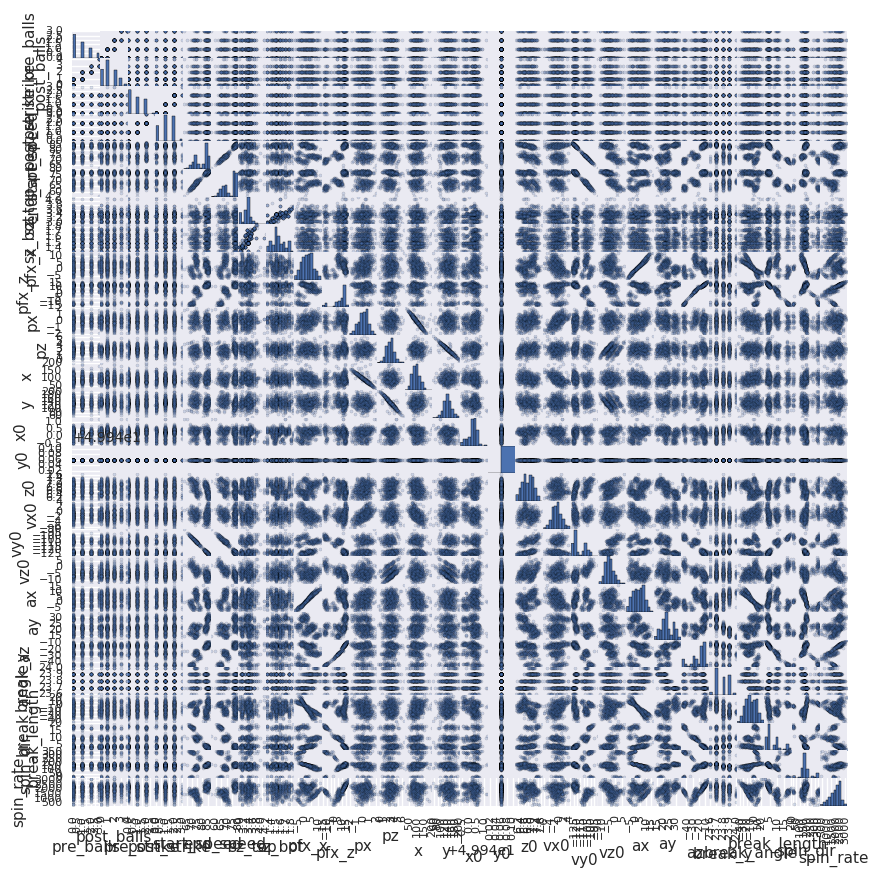

In [21]:
# create scatter matrix of numerical columns
pd.scatter_matrix(bz_pfxc.iloc[:500, :],
                  alpha=0.2,
                  figsize=(10, 10),)
plt.show()

Some combinations of columns reveal interesting information. First, there appear to be clusters forming in some of the panels (e.g., `start_speed` and `pfx_x`, and `start_speed` and `pfx_z`). Also, `y0` (the distance in feet from home plate where the PITCHf/x system is set to measure the initial parameters) is constant. Additionally, there are a number of highly-correlated columns (e.g., `x` and `px`).

Next, I'll look at the correlations between pairs of columns by computing a correlation matrix (I remove `y0` from the data to clean up the correlation matrix).

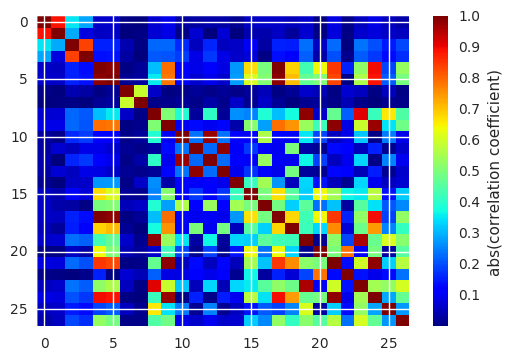

In [22]:
# visualize correlation matrix
bz_pfxc = bz_pfxc.drop(["y0"], 1)
pcorr = np.corrcoef(bz_pfxc.T)
plt.imshow(abs(pcorr),
           aspect='auto',
           cmap="jet",
           interpolation="none",)
plt.colorbar(label="abs(correlation coefficient)")
plt.show()

A number of columns have very high correlation coefficients, even off of the diagonal. I'll take a closer look at the columns that have absolute values of correlation coefficients over 0.975.

In [23]:
# find columns with high correlation
hcorr = np.argwhere(np.logical_and(abs(pcorr)>0.975, pcorr!=1))

# convert indices to columns
for ii in hcorr:
    print(bz_pfxc.columns[ii[0]], bz_pfxc.columns[ii[1]],)

start_speed end_speed
start_speed vy0
end_speed start_speed
end_speed vy0
pfx_x ax
pfx_z az
px x
pz y
x px
y pz
vy0 start_speed
vy0 end_speed
ax pfx_x
az pfx_z
az break_length
break_length az


Now there is a list of columns that have redundant information. Not surprisingly, columns related to speed are highly correlated, while columns related to movement are also correlated.

### Pitch separation

Time to give pitch separation another try, this time focusing on only one pitcher (Zito) instead of all pitchers. As before, I'll create crossplots of movements, velocity, and given pitch classifications and see if they can visually be separated.

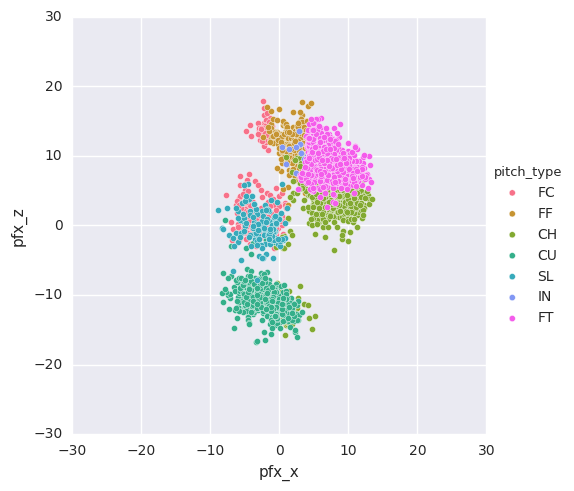

In [24]:
# plot crossplot over movements
sns.pairplot(x_vars="pfx_x",
             y_vars="pfx_z",
             data=bz_pfx,
             hue="pitch_type",
             size=5,)
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.show()

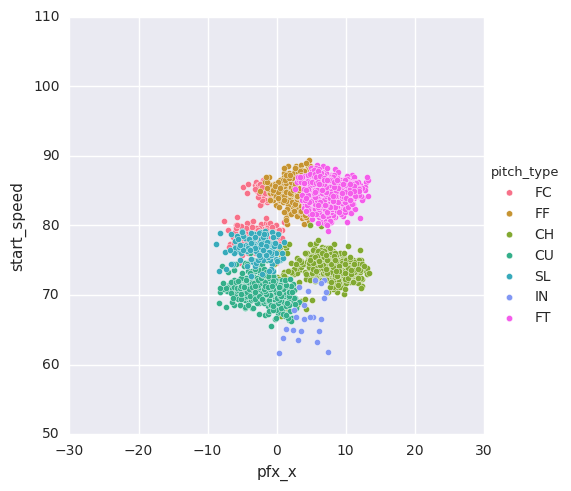

In [25]:
# plot crossplot over horizontal movement and velocity
sns.pairplot(x_vars="pfx_x",
             y_vars="start_speed",
             data=bz_pfx,
             hue="pitch_type",
             size=5,)
plt.xlim(-30, 30)
plt.ylim(50, 110)
plt.show()

There is clear separation between apparent pitch types, particularly when looking at speed against horizontal movement. However, while the clustering is pretty clear, there are some issues classifying the cutter, as it is grouped with both the fastballs (FF and FT) and the slider (SL).

Thus, if one wants to work with pitch labels, it may be a good idea to try to personally classify pitches, potentially via a clustering method.

## Dimensionality reduction

Previously, it was clear that a number of columns are highly correlated. There are a number of ways to reduce high-dimensional data into a lower-dimensional representation of the data. I'll look at principal component analysis (PCA) here.

PCA aims to map data to a lower-dimensional space in such a way that the variance of the data in the low-dimensional representation is maximized. This is typically done by performing SVD on the data covariance matrix. Here, I will perform PCA on the numerical columns in Barry Zito's pitchfx information.

I'll work with the clean data, where indexing- and character-related columns have been removed. I'll first standardize the columns.

In [26]:
# standardize columns
bz_pfxc_stand = (bz_pfxc-bz_pfxc.mean())/bz_pfxc.std()

Next, I'll use sklearn's PCA program to perform dimensionality reduction.

In [27]:
# import pca
from sklearn.decomposition import PCA

# initialize and perform pca
pca = PCA(whiten=False)
bz_pfxc_pca = pca.fit(bz_pfxc_stand)

Next, I'll look at the proportion of variance explained as a function of principal component. I'll plot a horizontal line at 90% variance explained.

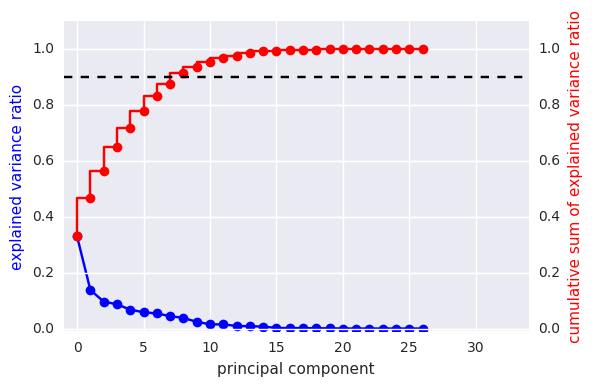

In [28]:
# plot variance ratio against principal component
fig, ax1 = plt.subplots()
ax1.plot(bz_pfxc_pca.explained_variance_ratio_, "o-", color="b")
ax1.set_xlabel("principal component")
ax1.set_ylabel("explained variance ratio")
ax1.set_ylim([-0.01, 1.1])
ax1.yaxis.label.set_color('b')

# plot cumulative sum of explained variance ratio against principal component
ax2 = ax1.twinx()
ax2.step(np.cumsum(bz_pfxc_pca.explained_variance_ratio_), "o-", color="r")
ax2.set_ylabel("cumulative sum of explained variance ratio")
ax2.set_xlim([-1, 34])
ax2.set_ylim([-0.01, 1.1])
ax2.yaxis.label.set_color('r')
ax2.axhline(y=0.9, color="k", ls="dashed")
plt.show()

The first principal component accounts for over 30% of the variance in the data, while the second component accounts for 15% of the variance in the data, which is quite a drop-off from the first principal component. Note that 9 principal components (out of 26) are needed to explain over 90% of the variance in the data.

Next, I'll take a look at the loadings of the first four principal components to get a sense of how the principal components are correlated to the original columns.

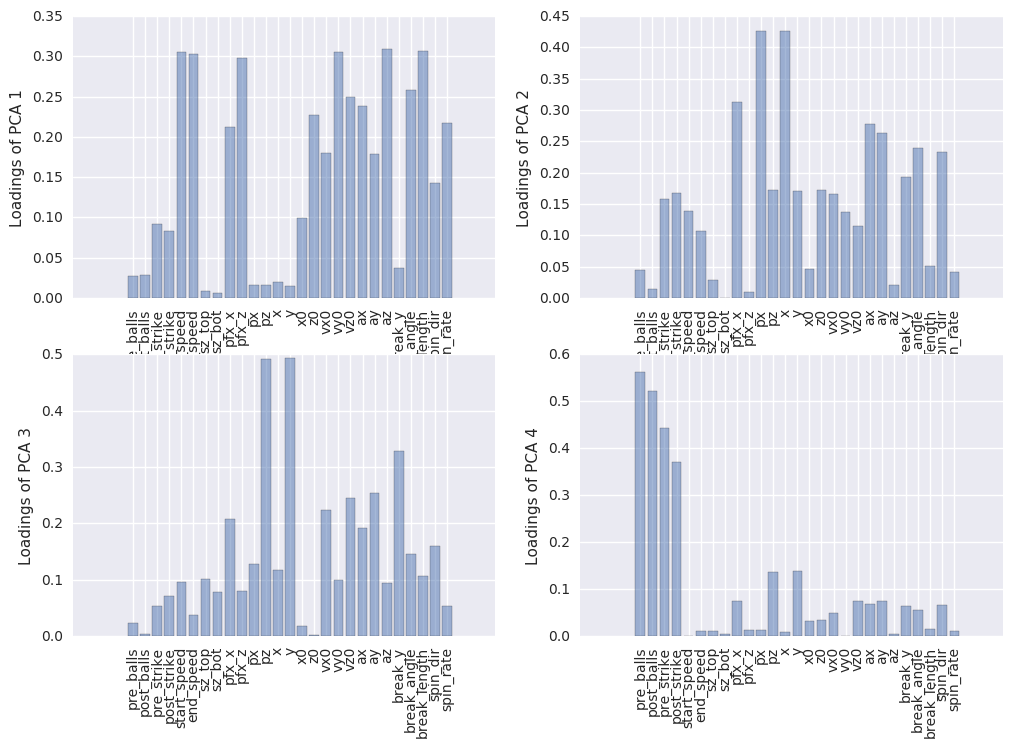

In [29]:
# intialize figure
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# plot loadings
for ii in range(2):
    for jj in range(2):
        loadings = bz_pfxc_pca.components_[2*ii+jj, :]
        # plot barchart of loadings
        ax[ii, jj].bar(range(len(loadings)), np.abs(loadings), align='center', alpha=0.5)
        ax[ii, jj].set_ylabel("Loadings of PCA %s" %(2*ii+jj+1))
        plt.sca(ax[ii, jj])
        plt.xticks(range(len(loadings)), list(bz_pfxc), rotation=90)
plt.show()

There are a number of observations to make here. The first is that the first principal component is strongly correlated with primarily the trajectory information of the pitch. The second principal component seems to be a measure of the horizontal location of the pitch, while the third component seems to be a measure of the vertical location of the pitch. The fourth component seems to be a measure of the pitch count at the time of the pitch.

Now I'll project the data onto the first two principal components, colored by the pitch classification from the database. I multiply the standardized data with the loadings to project the data in principal component space.

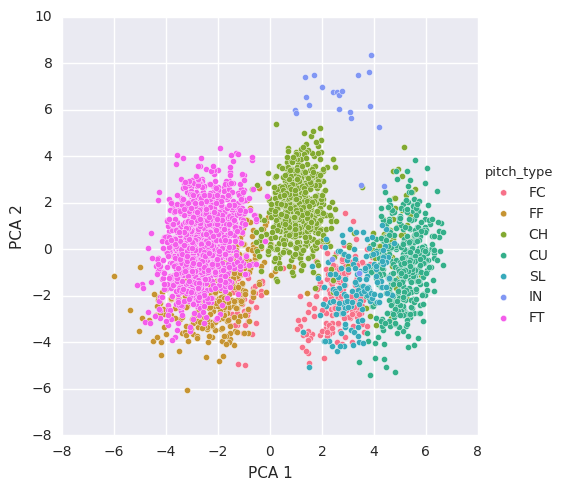

In [30]:
# create dataframe for plotting
ptemp = pd.DataFrame({"pca1":np.dot(bz_pfxc_stand, bz_pfxc_pca.components_[0, :]),
                      "pca2":np.dot(bz_pfxc_stand, bz_pfxc_pca.components_[1, :]),
                      "pitch_type":np.array(bz_pfx.pitch_type)}, )

# plot in pca space, colored by pitch type from database
sns.pairplot(x_vars="pca1", y_vars="pca2", data=ptemp, hue="pitch_type", size=5)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

Pitch types are best separated across the first principal component, which from the loadings seems to be a measurement of the trajectory information. Alternatively, the pitch types are poorly separated across the second principal component, which seems to be a measurement of horizontal pitch location. This result matches intuition that pitches are going to be distinguishable based on their velocities and movements and not where they cross the plate. Therefore, if looking to find clusters in the data, one might want to use only the trajectory information.

This is an example of where PCA is best not used on all columns if looking for clusters. PCA attempts to find a smaller set of variables that explains as much variability in the data as possible; it does not optimize for clusters. Therefore, columns that have high variance but are ultimately meaningless are effectively noise and can hurt the ability to find patterns in the data. For example, pitch location at the plate might display some variance, but it is not going to help extract clusters of pitches from the data. An example of a paper that tries to perform feature selection for unsupervised learning can be found here: http://www.jmlr.org/papers/volume5/dy04a/dy04a.pdf.

In [31]:
# clean up
hdb.close()